# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [1]:
import os
import xarray as xr
import rioxarray as rio
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mode

from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch


In [9]:
# paths
data_path = Path('../../data/')
log_path = Path('../../runs/')
figure_path = Path('../../LaTex/figures/')

# coordinates
csr = 'EPSG:2056'

# filter warnings
warnings.filterwarnings("ignore", message="angle from rectified to skew grid parameter lost in conversion to CF")


In [3]:
# function to reduce plotting resolution

def mode_reduction(block, axis):
        # Flatten the block and calculate the mode
        dim0, dim1, dim2, dim3 = block.shape
        flattened = block.transpose((0, 2, 1, 3)).reshape(dim0, dim2, -1)
        result = mode(flattened, axis=-1, nan_policy='omit').mode
        return result

def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    if reduction == 'mode':
        return da.coarsen(x=factor, y=factor, boundary="trim").reduce(mode_reduction).compute()
    else:
        return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


## Visualizations of the available Data

### Size of the 3 areas

In [4]:
# import .shp file
gdf = gpd.read_file(data_path / 'BL_QA_editedJK.shp')


In [5]:
# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

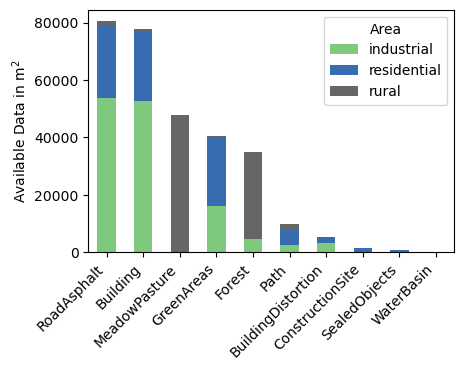

In [6]:
fig_filename = 'area_by_category.pdf'
image_size_cm = [12, 8]

fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Aggregate the grouped data
data = gdf.groupby(['QA_categor', 'area'])['Shape_Area'].sum().unstack().fillna(0)

# Sort the data by the total size of each QA_categor
data['Total'] = data.sum(axis=1)
data = data.sort_values('Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart
data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

ax.set_xlabel(None)
ax.set_ylabel('Available Data in m$^2$')
ax.legend(title='Area')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig(figure_path / fig_filename, bbox_inches='tight')
plt.show()


## Visualizations of the Results

### Loss and accuracy

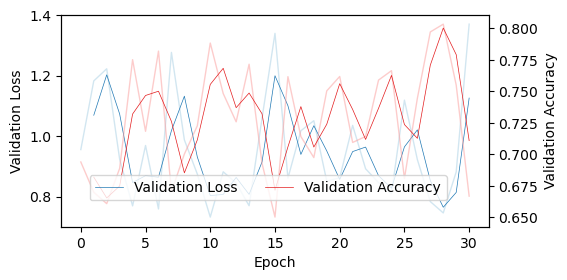

In [7]:
run = 'noaugment_complete'
metrics = pd.read_csv(log_path / run / 'metrics.csv')
image_size_cm = [14, 7]

validation_data = metrics[~metrics['valid_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['valid_loss'], window_size=2)
smoothed_val_acc = smooth_data(validation_data['valid_acc'], window_size=2)

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Plot unsmoothed valid_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['valid_loss'], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot valid_acc
ax2 = ax1.twinx()
# Plot unsmoothed valid_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['valid_acc'], color='#FB9A99', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=0.5)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)


### Visualizations of the Predictions

In [10]:
run = 'noaugment_complete'

# Load the dataset
ds_data = xr.open_zarr(log_path / run / 'preds.zarr')

# Access the 'label' variable
ds_label = ds_data['label']

print(ds_label)

KeyError: "No variable named 'label'. Variables on the dataset include ['cls', 'label_pred', 'label_prob', 'spatial_ref', 'training_mask', 'x', 'y']"

In [4]:
# # load training data
# ds_data = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
# ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

# areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

# # load predictions
# run = 'noaugment_complete'
# ds_predictions = xr.open_zarr(log_path / run / 'preds.zarr').rio.write_crs(csr).rename({"label_pred": "label"})

# ds_data_cors = coarsen(ds_data)
# ds_pred_cors = coarsen(ds_predictions)

KeyboardInterrupt: 

In [73]:
# ds_data = xr.open_zarr(data_path / 'combined.zarr').rio.write_crs(csr)
# ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

# areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

# area_labels = range(1,13)
    
# clipped_data = {}

# for area_label in area_labels:
#     clip_feature = areas[areas['DataLabel'] == area_label]
#     clipped_data[area_label] = ds_data.rio.clip(clip_feature.geometry, clip_feature.crs)


In [122]:
def calculate_normalized_rgb(
    ds: xr.Dataset, 
    gamma: float = 1.0, 
    clip_min: float = 0.0, 
    clip_max: float = 1.0
) -> np.ndarray:
    """
    Calculate normalized RGB from an xarray Dataset with optional scaling, gamma correction, and clipping.

    Parameters:
        ds (xr.Dataset): Input dataset containing the bands with dimensions ['band', 'x', 'y'].
        gamma (float): Gamma correction factor. Default is 1.0 (no gamma correction).
        clip_min (float): Minimum value for clipping. Default is 0.0.
        clip_max (float): Maximum value for clipping. Default is 1.0.

    Returns:
        np.ndarray: Normalized RGB image as a NumPy array with shape (H, W, 3) and values in [0, 1].
    """
    # Mask zero values with NaN to avoid skewing normalization
    ds = ds['rs'].where(ds['rs'] != 0, np.nan)

    # Select the respective bands
    red_band = ds.sel(band=2)
    green_band = ds.sel(band=3)
    blue_band = ds.sel(band=4)

    # Scale values to [0, 1] range before any processing
    def scale_to_unit(array):
        return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

    red_scaled = scale_to_unit(red_band)
    green_scaled = scale_to_unit(green_band)
    blue_scaled = scale_to_unit(blue_band)

    # Function to normalize an array with clipping
    def normalize(array):
        # Clip values to specified range
        clipped = np.clip(array, clip_min, clip_max)
        # Normalize to [0, 1]
        return (clipped - np.nanmin(clipped)) / (np.nanmax(clipped) - np.nanmin(clipped))

    # Normalize each band with scaling, clipping, and gamma correction
    red_normalized = normalize(np.power(red_scaled, gamma))
    green_normalized = normalize(np.power(green_scaled, gamma))
    blue_normalized = normalize(np.power(blue_scaled, gamma))

    # Stack bands into an RGB array
    rgb = np.dstack((red_normalized, green_normalized, blue_normalized))

    return rgb

In [121]:
rgb_norm_settings = {
    '1': {'gamma': 0.7, 'clip_min': 0.1, 'clip_max': 0.95},
    '2': {'gamma': 0.65, 'clip_min': 0.0, 'clip_max': 0.94},
    '3': {'gamma': 0.8, 'clip_min': 0.0, 'clip_max': 1.0},
    '4': {'gamma': 0.8, 'clip_min': 0.0, 'clip_max': 1.0},
    '5': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '6': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '7': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '8': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '9': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '10': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '11': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8},
    '12': {'gamma': 0.4, 'clip_min': 0.07, 'clip_max': 0.8}
}

class_info = {
    0: ["ConstructionSite", "#B5E4FF"],
    1: ["Building", "#C5FEB6"],
    2: ["BuildingDistortion", "#900C3F"],
    3: ["GreenAreas", "#FEE8C2"],
    4: ["RoadAsphalt", "#FAB6FE"],
    5: ["Forest", "#C0B2FD"],
    7: ["Path","#EED7FF"],
    6: ["WaterBasin", "#F4FFB3"],
    8: ["MeadowPasture", "#CEFEEB"],
    9: ["SealedObjects", "#FED7D1"],
}

sealed_dict = {
            0: ["unsealed","#B6FFB8"],
            1: ["sealed", "#FDECCF"],
            2: ["unknown", "#FBB4AE"]
        }

# Generating Colormap and Norm
sorted_classes = sorted(class_info.keys())
colors = [class_info[key][1] for key in sorted_classes]

class_cmap = ListedColormap(colors)
bounds = list(sorted_classes) + [sorted_classes[-1] + 1]
norm = BoundaryNorm(bounds, class_cmap.N)

# Define the custom colormap for 0 (blue) and 1 (red)
diff_info = {
    10: ["Correct Prediction", "#7CB9E8"],
    11: ["Incorrect Prediction", "#FF6F91"],
}

dif_cmap = ListedColormap([diff_info[10][1], diff_info[11][1]])

legend_info = {**class_info, **diff_info}
legend_elements = [Patch(facecolor=legend_info[key][1], label=legend_info[key][0]) for key in sorted(legend_info.keys())]

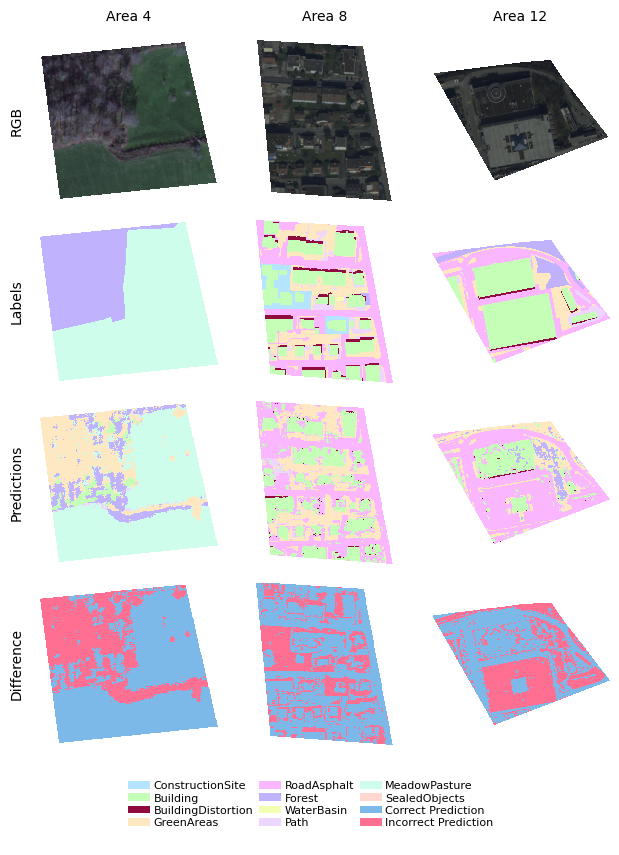

In [123]:
coarsen = False

run = 'noaugment_complete'

path_to_dataset = data_path / 'combined.zarr'
path_to_predictions = log_path / run / 'preds.zarr'
path_to_areas = data_path / 'AOI_Labeled.shp'

# load training data
ds_data = xr.open_zarr(path_to_dataset).rio.write_crs(csr)
ds_data["label"] = ds_data["label"].where(ds_data["label"] != 255, np.nan)

areas = gpd.read_file(path_to_areas)

# load predictions
run = 'noaugment_complete'
ds_predictions = xr.open_zarr(path_to_predictions).rio.write_crs(csr).rename({"label_pred": "label"})

if coarsen: # Still for all data the same coarsen function - needs fixing
    dataset = coarsen(ds_data)
    predictions = coarsen(ds_predictions)
else:
    dataset = ds_data
    predictions = ds_predictions


image_size_cm = [16, 22]

# Create GridSpec layout with 5 rows and 4 columns
fig = plt.figure(figsize=(image_size_cm[0] / 2.54, image_size_cm[1] / 2.54))
gs = GridSpec(6, 4, width_ratios=[0.05, 1, 1, 1], height_ratios=[0.05, 1, 1, 1, 1, 0.5], figure=fig)

# Titles for the rows
titles_views = ["RGB", "Labels", "Predictions", "Difference"]
area_labels = [4, 8, 12]


# Add rotated titles to the first column (col 0)
for i, title in enumerate(titles_views):
    ax_title = fig.add_subplot(gs[i+1, 0])  # Create an axis in the (i, 0) position
    ax_title.text(0.5, 0.5, title, fontsize=10, va='center', ha='center', rotation=90)
    ax_title.axis('off')  # Turn off the axis

# # Add colorbar axis
legend_ax = fig.add_subplot(gs[5, 0:5])
legend_ax.axis('off')
legend_ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=False,
    ncol=3,  # Number of columns for the legend items
    bbox_to_anchor=(0.5, 0.5),  # Center the legend in the axis
    fontsize=8,  # Smaller font size
    columnspacing=0.5,  # Reduce space between columns
    handletextpad=0.3,  # Reduce space between handles and labels
    borderpad=0.2,  # Reduce padding inside the legend box
    labelspacing=0.2  # Reduce vertical space between labels
)

for i, area_label in enumerate(area_labels):
    # add a title for the row
    ax_title = fig.add_subplot(gs[0, i+1])
    ax_title.text(0.5, 0.5, f'Area {area_label}', fontsize=10, va='center', ha='center')
    ax_title.axis('off')

    # Clip the dataset and predictions to the current area
    clip_feature = areas[areas['DataLabel'] == area_label]
    clipped_dataset = dataset.rio.clip(clip_feature.geometry, clip_feature.crs)
    clipped_predictions = predictions.rio.clip(clip_feature.geometry, clip_feature.crs)

    # plottin RGB
    rs = clipped_dataset['rs']
    rgb = calculate_normalized_rgb(ds = clipped_dataset, **rgb_norm_settings[f'{area_label}']).transpose((1, 0, 2))
    ax_rgb = fig.add_subplot(gs[1, i+1])
    ax_rgb.imshow(rgb)
    ax_rgb.axis('off')

    # Plotting labels
    labels = clipped_dataset['label'].transpose('y', 'x')
    ax_labels = fig.add_subplot(gs[2, i+1])
    ax_labels.imshow(labels, cmap=class_cmap, norm=norm, interpolation="nearest")
    ax_labels.axis('off')

    # Plotting predictions
    pred_labels = clipped_predictions['label'].transpose('y', 'x')
    ax_predictions = fig.add_subplot(gs[3, i+1])
    ax_predictions.imshow(pred_labels, cmap=class_cmap, norm=norm, interpolation="nearest")
    ax_predictions.axis('off')

    # Plotting difference
    difference = labels - pred_labels
    difference_std = xr.where(np.isnan(difference), np.nan, xr.where(difference == 0, 0, 1))
    ax_difference = fig.add_subplot(gs[4, i+1])
    ax_difference.imshow(difference_std, cmap=dif_cmap, interpolation="nearest")
    ax_difference.axis('off')

plt.subplots_adjust(
    hspace=0.1,  # Adjust vertical spacing
    wspace=0.1   # Adjust horizontal spacing
)

fig.tight_layout()
plt.show()
